# Permutation test against null distribution of respiratory phase angles
This notebook demonstrates how to make a permutation-based test to determine whether events (e.g., target stimuli) tend to occur at a specific phase of the respiratory cycle. As some phase angles are more common than others (exhalation tend to last longer than inspiration), we compare the observed phase angles at stimulus onset to a null distribution derived from the underlying respiratory signal. 

In this notebook, we determine whether target stimuli tend to occur at a specific phase of the respiratory cycle.  
To do this, we perform a **permutation-based test** that compares the observed phase angles at stimulus onset to a null distribution derived from the underlying respiratory signal.

At first, we import the necessary Python modules:

In [31]:
import pickle
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt


from pyriodic.circular import Circular
from pyriodic.viz import CircPlot
from pyriodic.permutation import permutation_test_against_null

## Single-level analysis


In [32]:
data_path = Path("../../data/respiration/intermediate")
subj_id = "0019"
file_path = data_path / f"participant_{subj_id}_preproc.pkl"

with open(file_path, 'rb') as f:
            data = pickle.load(f)

PA_events = data["phase_angle_events"]
PA = data["phase_angles"]


print(type(PA_events), type(PA))

<class 'pyriodic.phase_events.PhaseEvents'> <class 'numpy.ndarray'>


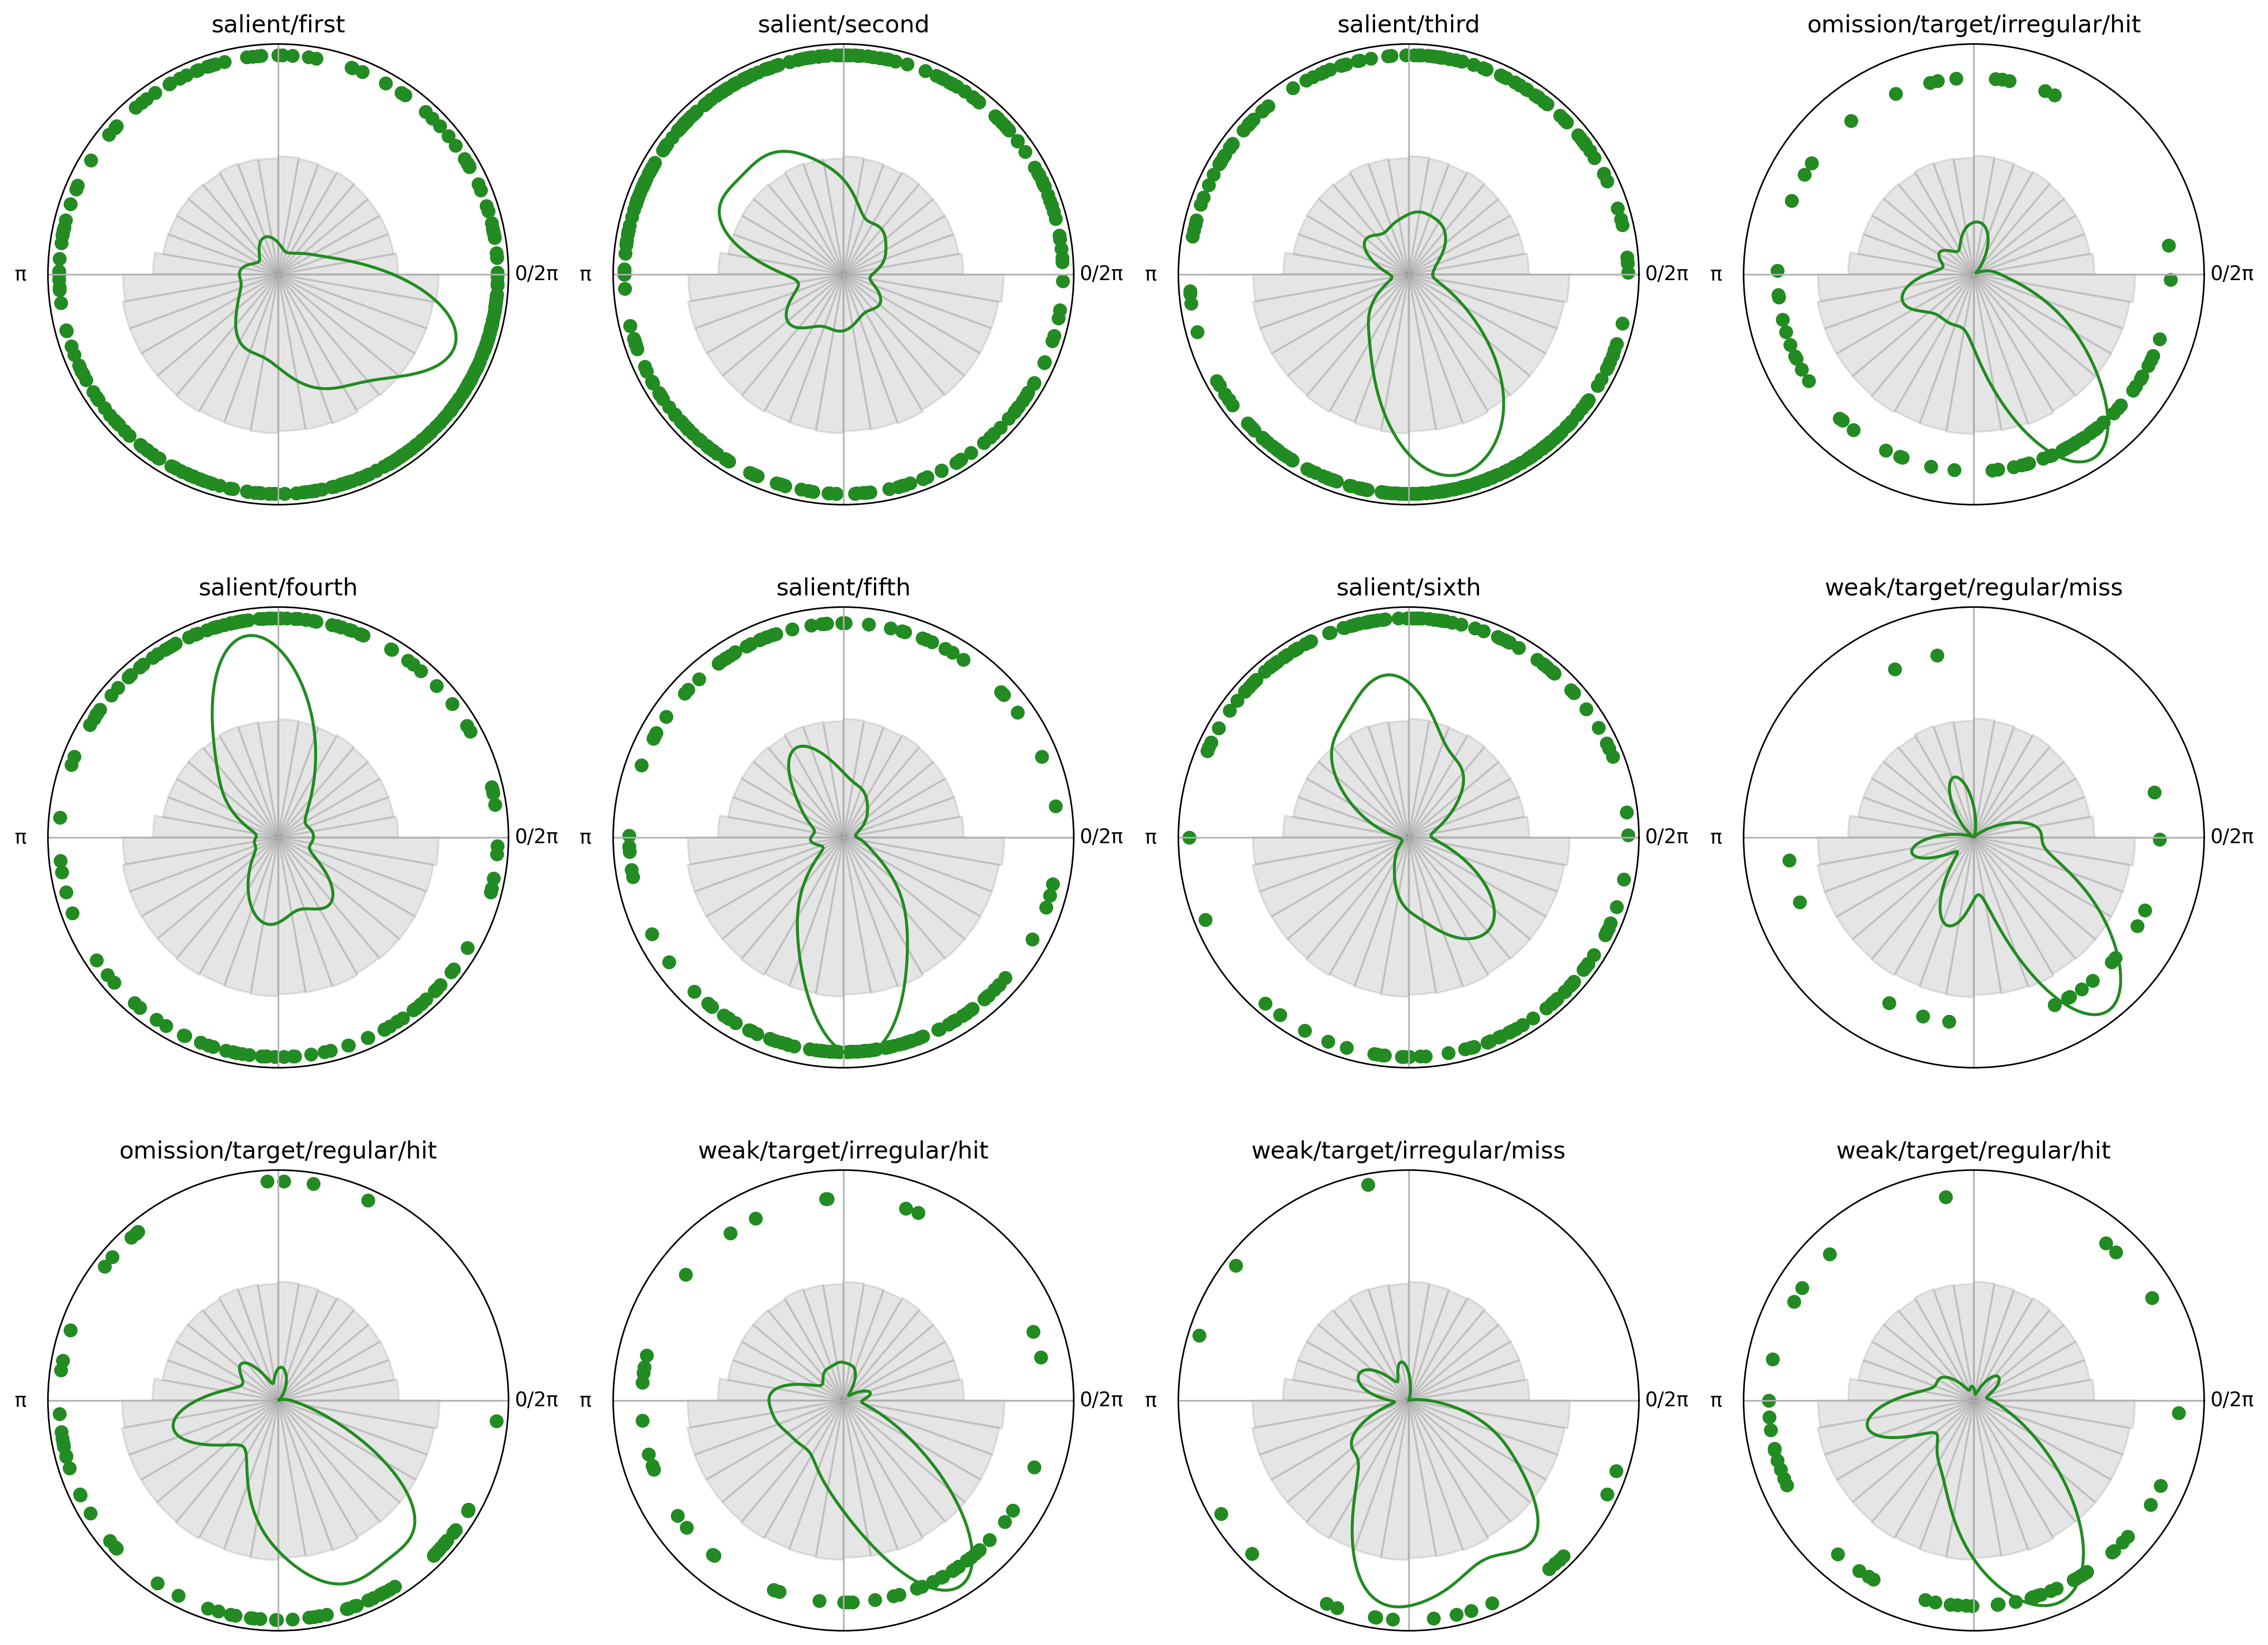

In [33]:
PA_events.plot(
    histogram=PA
    )

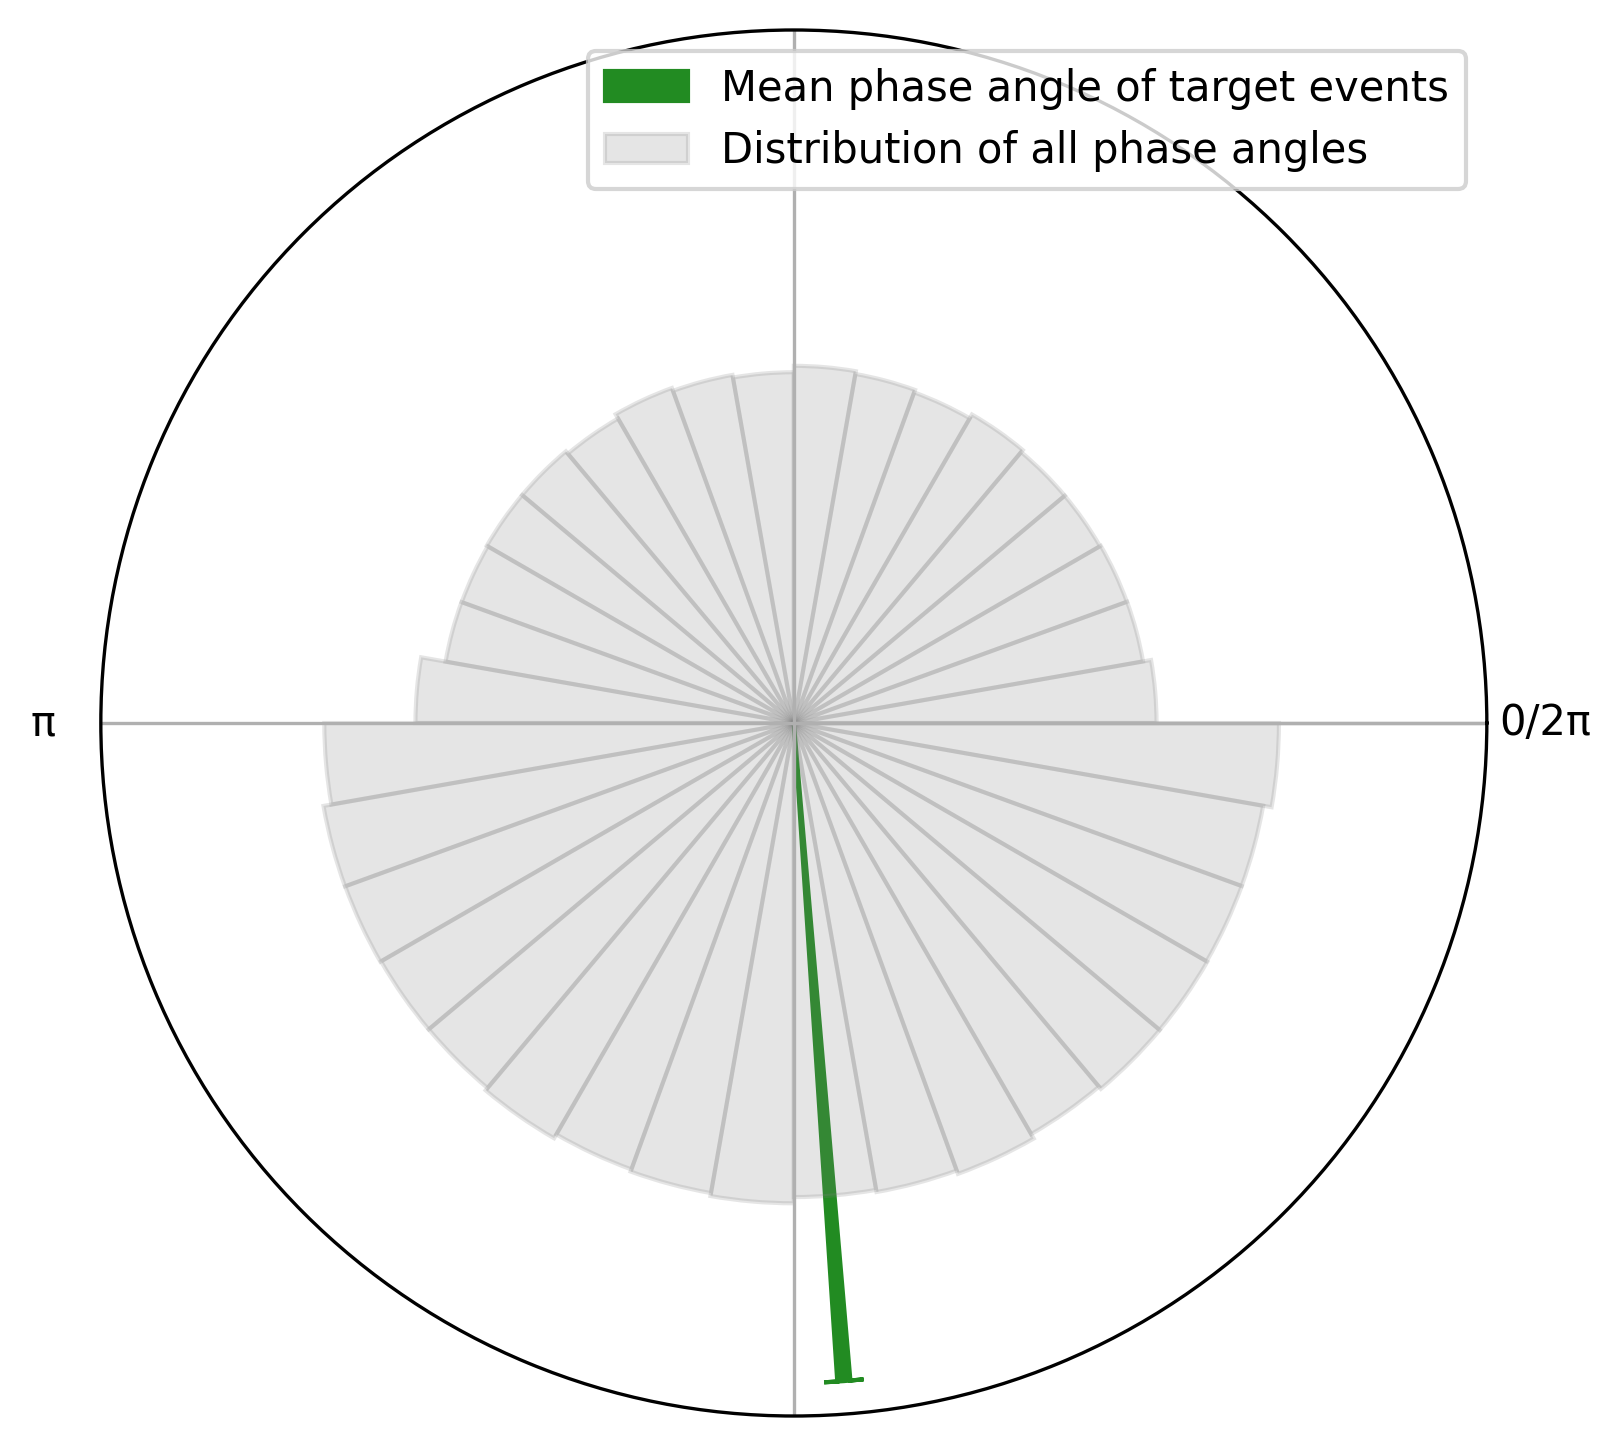

In [34]:
# lets generate a circular object with all the target events combined, and do a quick plot just to get an overview
circ_target = PA_events.to_circular(include="target")


plot = CircPlot(circ_target, group_by_labels=False)
plot.add_circular_mean(label = "Mean phase angle of target events")
plot.add_histogram(PA, label = "Distribution of all phase angles")
plot.add_legend()

To test whether the phase of respiration aligns with the specific events, for example target stimuli, one must account for the fact that respiratory phase is typically not uniformly distributed. For example, expiration may occupy a longer portion of the cycle, making it more likely for events to fall within that phase by chance alone.

To address this, we employ a permutation-based framework in which the observed phase distribution of events is compared to a null distribution constructed from randomly sampled phase angles drawn from the phase angle time series. 

Internally, the function:
1. Generates $n$ null samples by randomly drawing phase angles from the respiration signal, with each sample containing the same number of events as in the observed data.
2. Computes the test statistic (e.g., Watson’s $U^2$) between the observed phase distribution and each of the null samples. These values are then averaged to yield a single observed test statistic.
3. Constructs a null distribution by computing the test statistic between randomly paired null samples (i.e., null-vs-null comparisons).
4. Calculates a p-value as the proportion of null-vs-null test statistics that exceed the averaged observed test statistic.


By default a discretised version of Watson’s $U^2$ statistic is used as the test statistics. 
$$U^2 = \frac{1}{k} \sum_{j=1}^{k} \left[ F(j) - G(j) \right]^2$$
where $k is the number of phase bins, $F(j)$ is the cumulative proportion up to bin $j$ in the first sample, and $G(j)$ is the cumulative proportion in the second sample.

Watson’s $U^2$ statistic can thus be interpreted as a measure of distributional difference between two circular samples, with larger values indicating greater divergence in their cumulative phase distributions.

In this case, a significant p-value indicates that the distribution of phase angles at which events occur is more different from the underlying respiratory phase distribution than would be expected by chance. Specifically, the observed data deviate more from the background than randomly drawn samples from that same background deviate from each other. Since Watson’s $U^2$ measures the difference between cumulative distributions, this result suggests that event timing is not randomly aligned with the respiratory cycle, but instead shows a systematic phase dependence.

This is implemented in the `permutation_test_against_null` function in Pyriodic. It takes a `Circular` object containing the phase angles of interest (e.g., target stimuli) and a `Circular` object containing the full respiratory cycle phase angles.


In [35]:
# Run permutation test
obs_stat, pval, null_samples = permutation_test_against_null(
    circ_target.data,
    PA,
    n_null = 10000,
    return_null_samples=True)

Observed statistic = 0.839, p = 0.0001


Let's visually compare the observed phase angles of the target stimuli to a null distribution of phase angles drawn from the full respiratory cycle by plotting the mean resultant vector length and the mean angle for both the observed target phase angles and a sample of null phase angles.

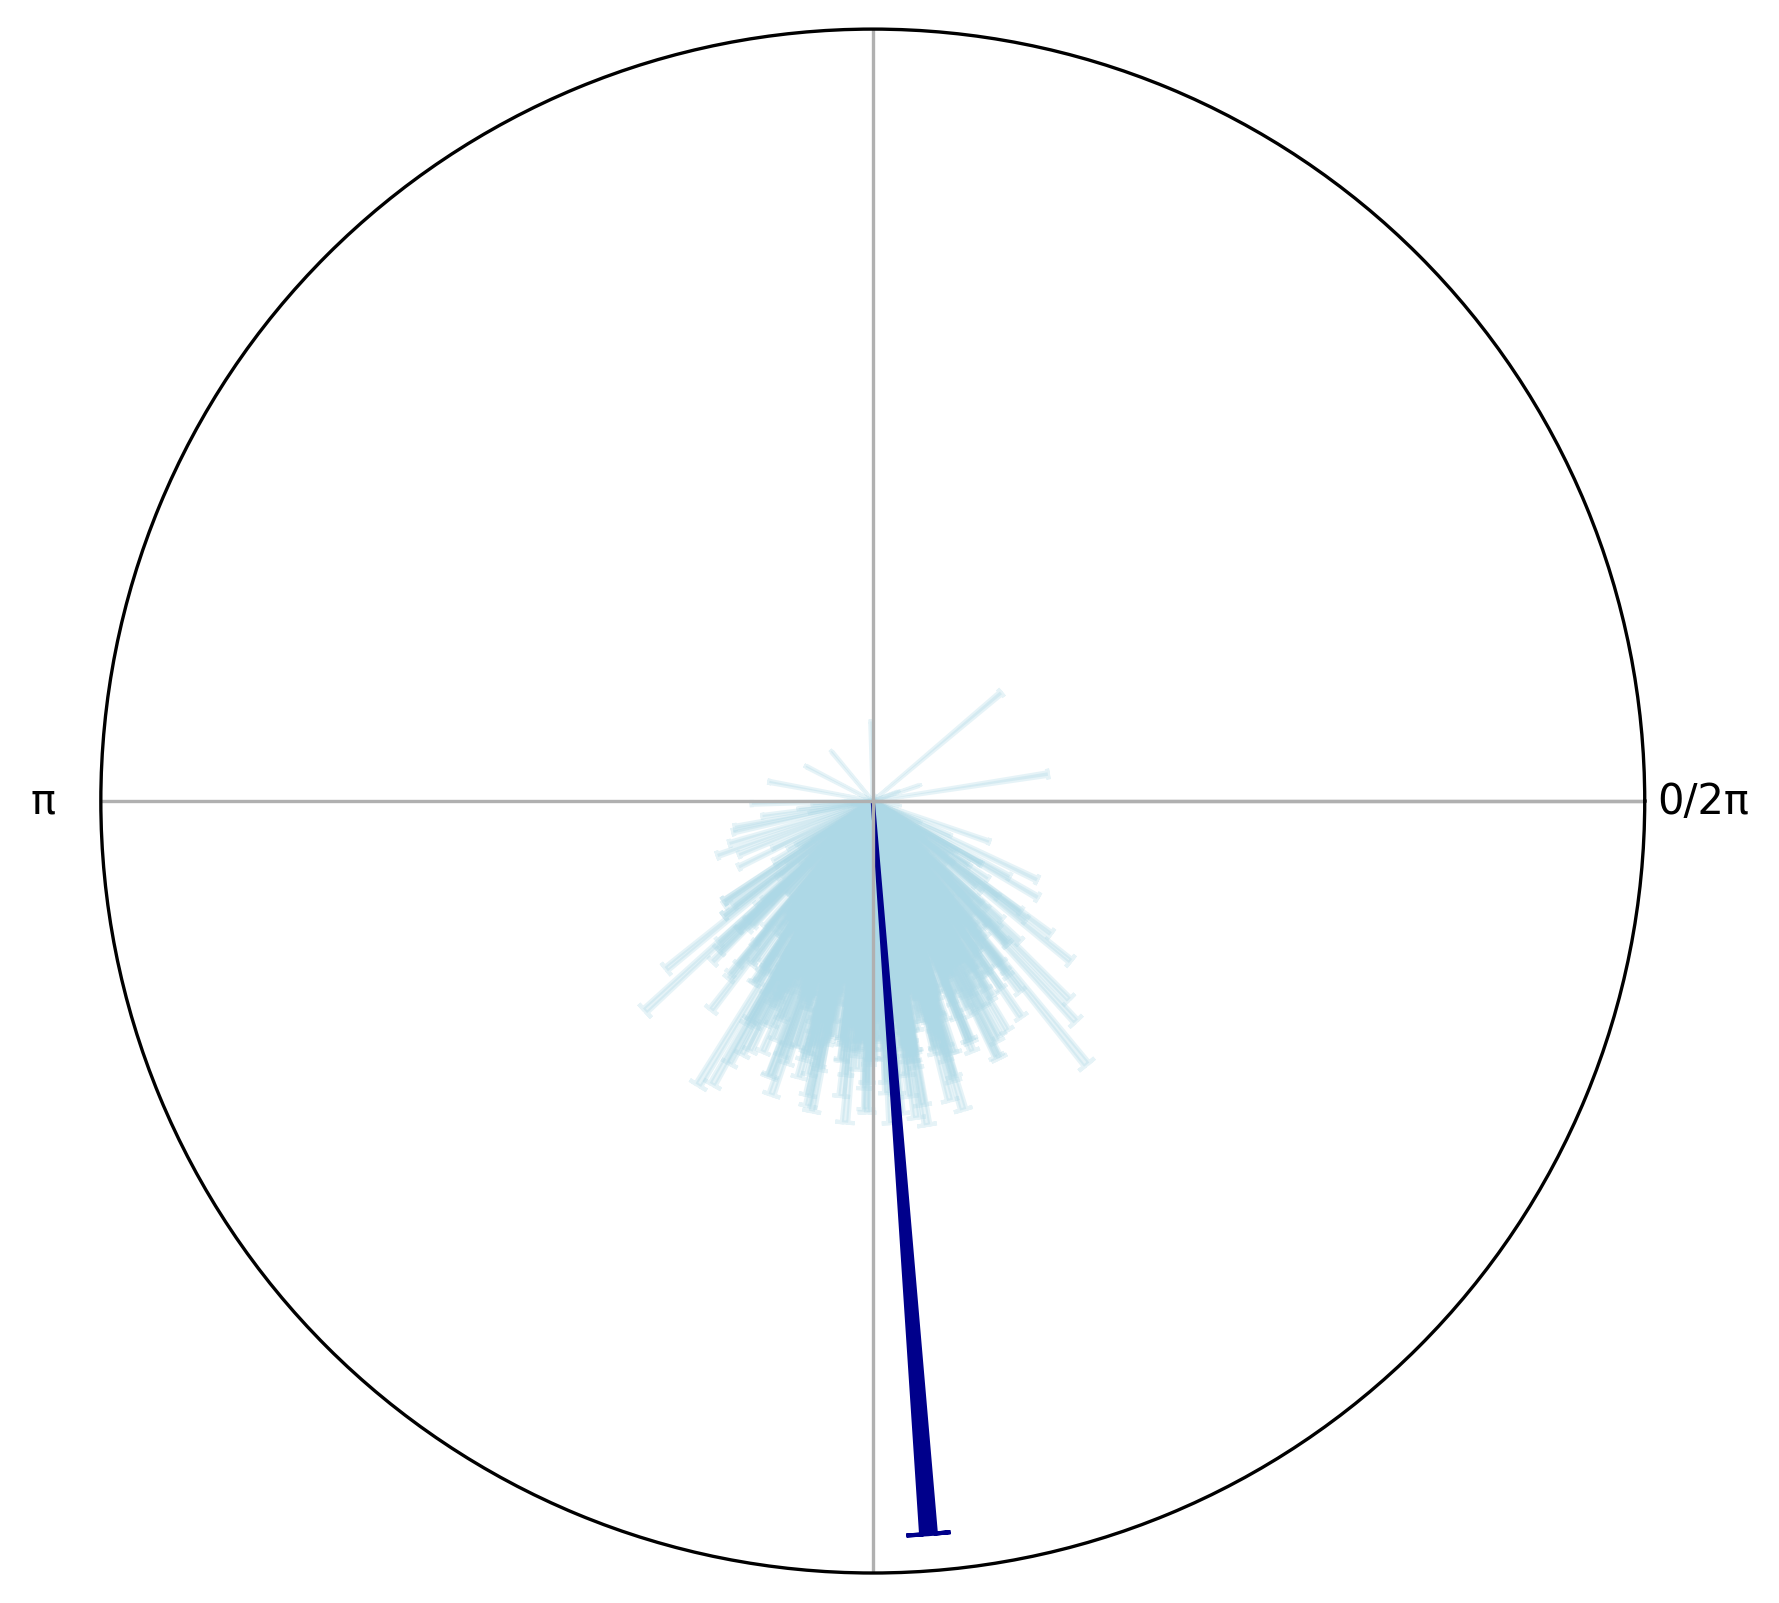

In [36]:
# make a circular object with the null_samples for plotting
circ_null = Circular.from_multiple(
    [Circular(samp, labels=[i]*len(samp)) for i, samp in enumerate(null_samples[:1000, :])] # only plotting 1000 null samples for speed
)

circplot_null = CircPlot(circ_null)
circplot_null.add_circular_mean(color = "lightblue", alpha = 0.3)
circplot_null.add_arrows(
    np.array([circ_target.mean()]),
    np.array([circ_target.r()]),
    color="darkblue"
)

plt.tight_layout()

We can see the lenght of the resultant vector for the target phase angles is larger than the means from the null distribution samples, indicating that the target phase angles are more aligned with a specific phase of the respiratory cycle than would be expected by chance as found using the permutation test. 

## Group-level analysis

In [37]:
results = {}
pas = {}

for file_path in data_path.iterdir(): 
    subj_id = file_path.name.split("_")[1]
    with open(file_path, 'rb') as f:
            data = pickle.load(f)

    results[subj_id] = data["phase_angle_events"]
    pas[subj_id] = data["phase_angles"]


In [38]:
# developer note: maybe make a function for this in the future???


rng = np.random.default_rng(seed=42)
n_permutations = 1000

group_observed_stats = []
group_null_stats = []
group_pvals = []

group_null_samples = {}

for subj_id in results:
    observed = results[subj_id].to_circular()
    pa = pas[subj_id]
    n_events = len(observed.data)

    # Create subject-specific permutations
    null_samples = [
        rng.choice(pa, size=n_events, replace=False)
        for _ in range(n_permutations)
    ]

    group_null_samples[subj_id] = Circular.from_multiple(
        [Circular(samp, labels=[i]*len(samp)) for i, samp in enumerate(null_samples)]
    )

    # Run subject-level permutation test
    obs, pval, null = permutation_test_against_null(
        observed=observed.data,
        phase_pool=pa,
        n_null=2000,
        rng=rng,
        verbose=False,
        return_null_distribution=True
    )

    group_observed_stats.append(obs)
    group_null_stats.append(null)
    group_pvals.append(pval)

# Group-level observed statistic: average of subject-level observed stats
# On average, do subjects show evidence of non-random timing with respect to respiratory phase?
group_obs = np.mean(group_observed_stats)

# Group-level null: average of null stats across subjects, per null_stat
# Reference distribution of what kind of group-level effect you’d expect if all subjects were random
group_null = [
    np.mean([nulls[i] for nulls in group_null_stats])
    for i in range(n_permutations)
]

# Group-level p-value
p_val = (np.sum(np.array(group_null) >= group_obs) + 1) / (len(group_null) + 1)

print(f"Group-level statistic = {group_obs:.3f}, p = {p_val:.4f}")


Group-level statistic = 0.023, p = 0.0010


### Is this effect consistent across all participants?

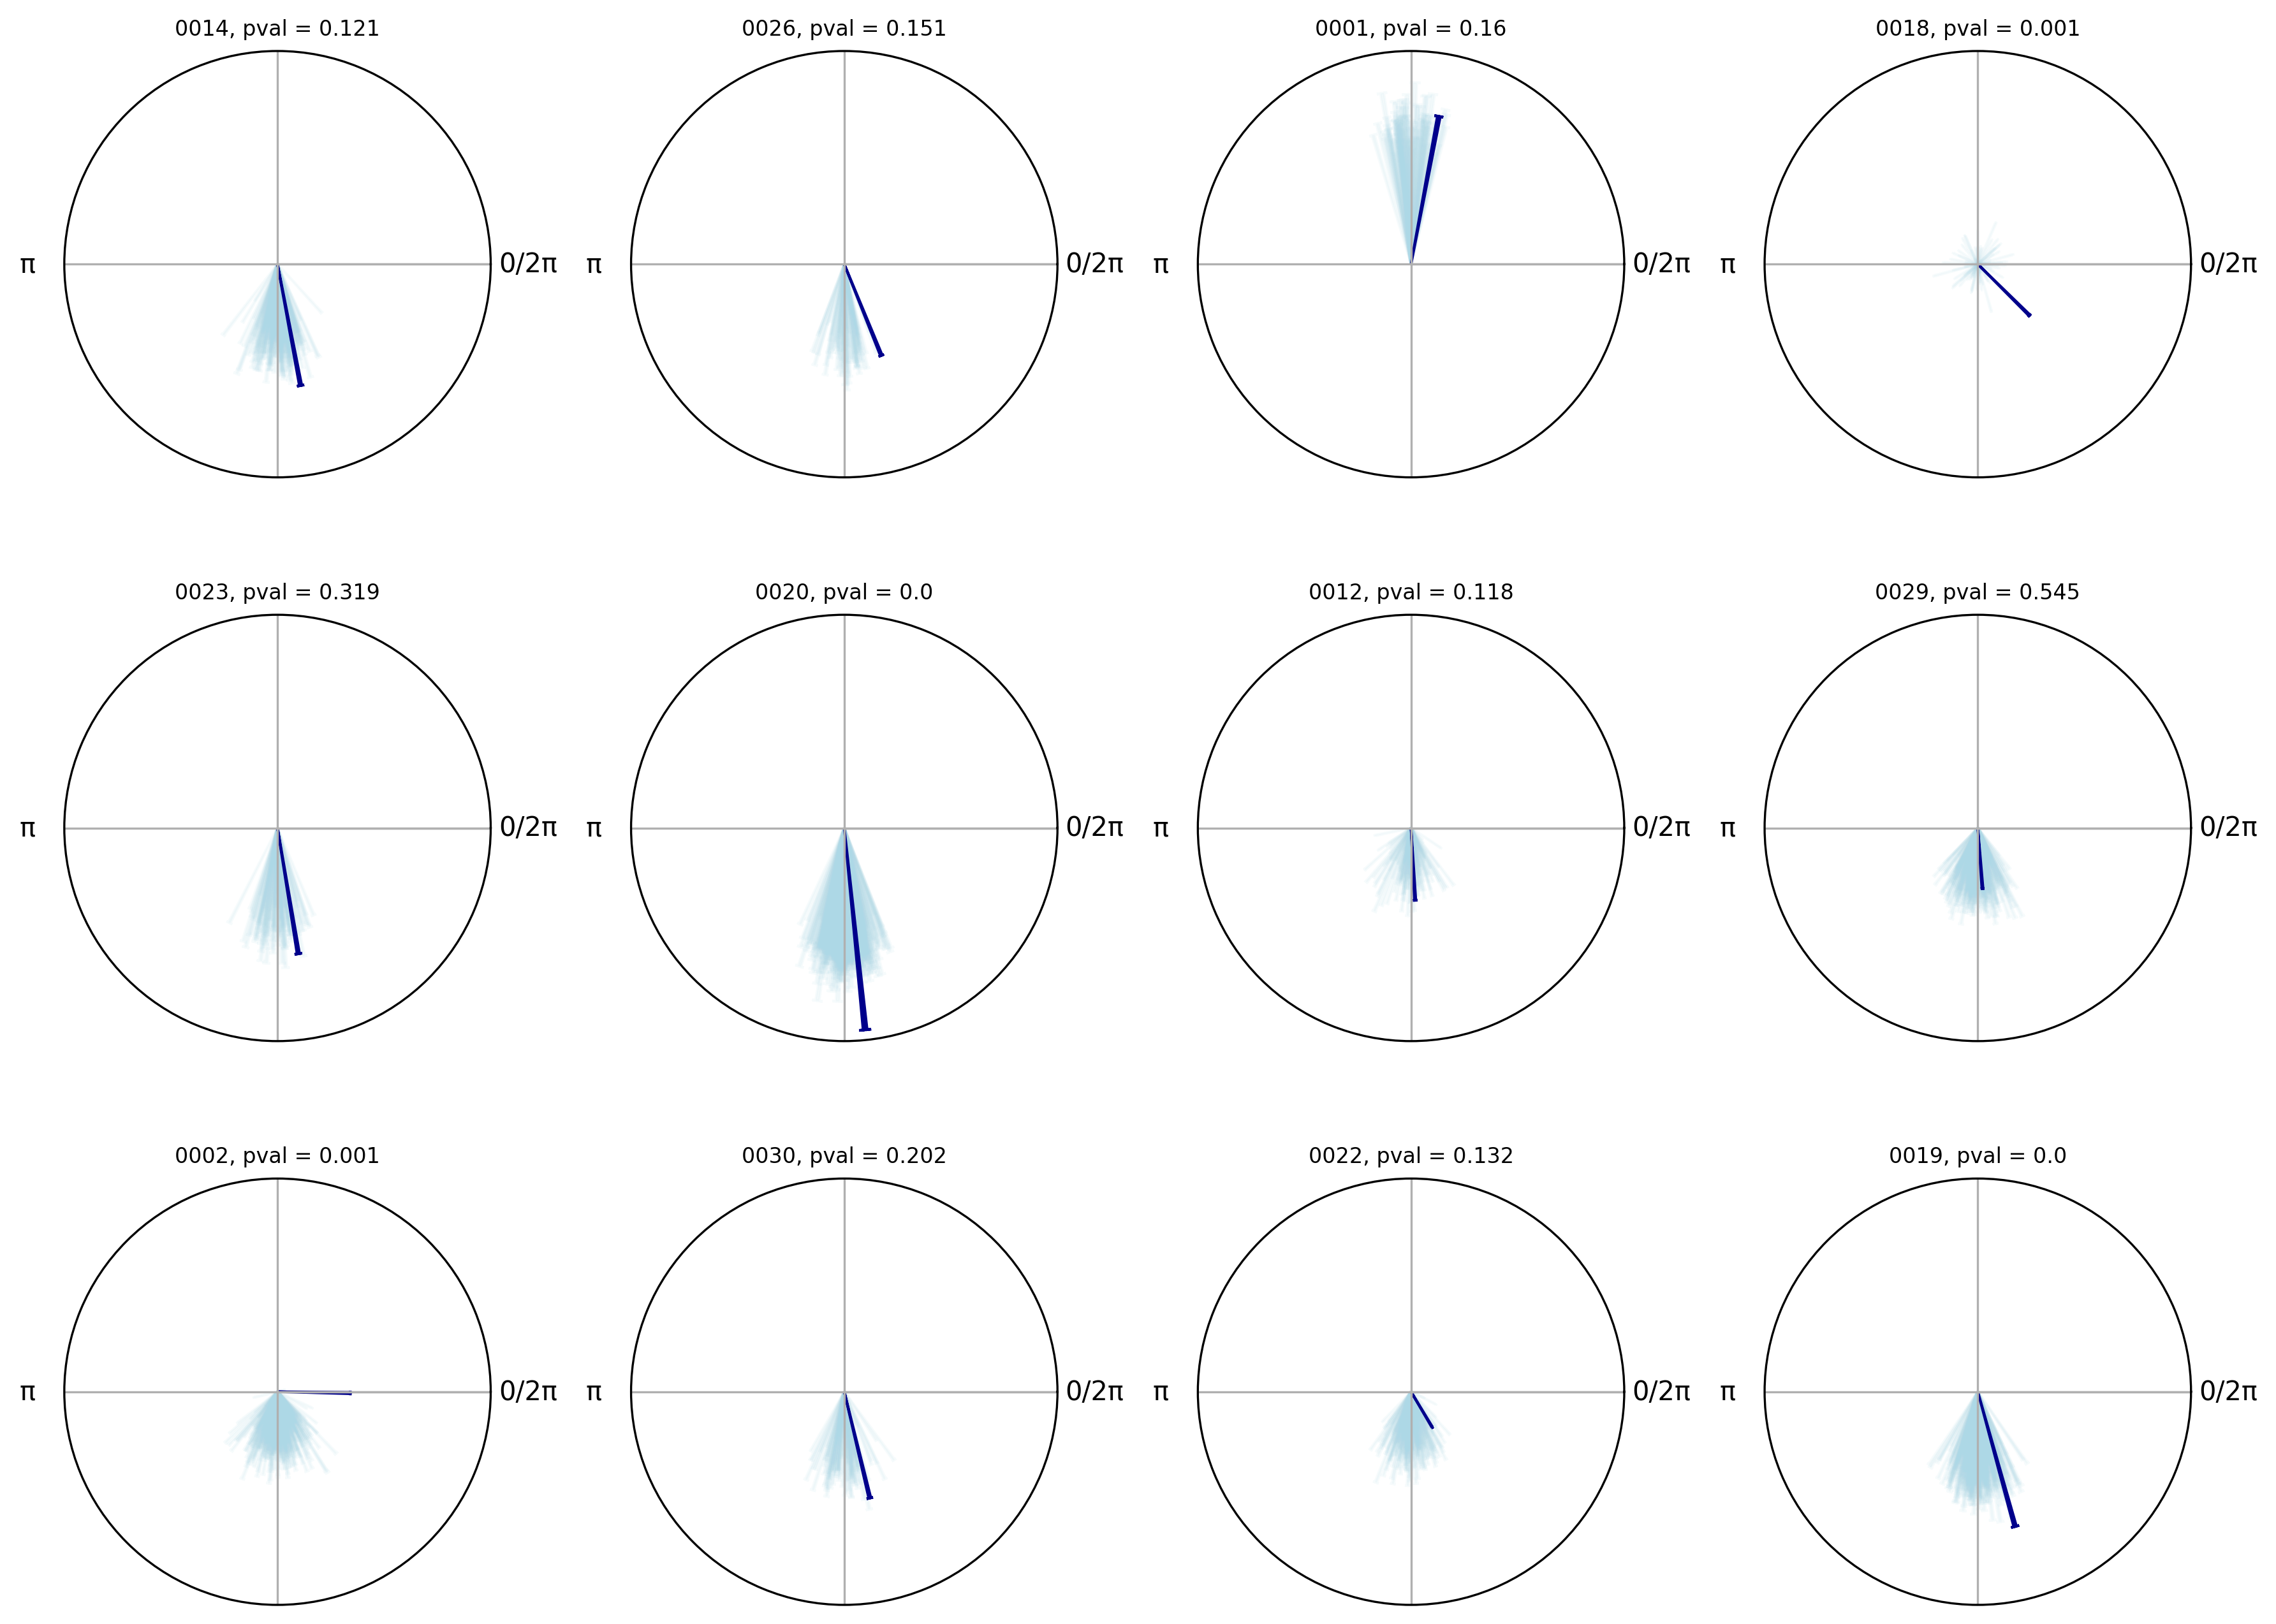

In [39]:
n_subjects = 12

n_cols = 4 
n_rows = math.ceil(n_subjects / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols, 
    dpi = 300, 
    figsize = (n_cols*3, n_rows*3), 
    subplot_kw={'projection': 'polar'},
    sharex=True,
    sharey=True
)

axes = axes.flatten()


for i, subj_id in enumerate(results):
    if i < n_subjects:
        circ_obs = results[subj_id].to_circular()
        circ_null = group_null_samples[subj_id]
        ax = axes[i]

        tmp_plot = CircPlot(circ_null, ax=ax)
        tmp_plot.add_circular_mean(alpha = 0.1, color = "lightblue")
        tmp_plot.add_arrows([circ_obs.mean()], [circ_obs.r()], label = "Observed", color = "darkblue")

        ax.set_title(f"{subj_id}, pval = {group_pvals[i].round(3)}", fontsize=8)


# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")


# aesthetics 
angles = [0, 90, 180, 270, 360]
labels = ["0/2π", "", "π", "", ""]

for ax in axes:
    ax.set_thetagrids(angles, labels=labels)

plt.tight_layout()
